# Step 3, TreeModel_with_service_requests: Create a Random Forest Model to predict street tree falls USING service requests
** Note that throughout this and other jupyter notebooks, the following terminology is used:
- falls: refer to fallen branches (from the 311 service request dataset) since 2015
- service requests: refer to 311 service requests for damaged trees or overhanging branches (but NOT fallen branches) since 2015
- tree census: refers to the 2015 NYC Street Tree Census

Packages

In [1]:
# Import packages
%matplotlib inline
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from inspect import signature

### Import model data from DataJoin

In [ ]:
model_data_df = pd.read_csv('Data/Intermediate/model_data.csv',index_col='tree_id')

### Edit model data for modeling
Encode categorical data

In [7]:
# Encode categorical dataa

# First convert all Yes/No and True/False columns to 1/0
model_data_df.replace({'No': 0, 'Yes': 1},value=None,inplace=True)
model_data_df.replace({False: 0, True: 1},value=None,inplace=True)
model_data_df.replace(np.nan,0,inplace=True)

# Now convert all 2 option columns to 1/0
model_data_df.curb_loc.replace({'OnCurb':1, 'OffsetFromCurb':0},value=None,inplace=True)
model_data_df.sidewalk.replace({'Damage':1, 'NoDamage':0},value=None,inplace=True)
model_data_df.Fall.replace('Branch or Limb Has Fallen Down',1,inplace=True)

# Replace health, steward, and guards columns with numerical levels
model_data_df.health.replace({'Poor':0,'Fair':1,'Good':2},value=None,inplace=True)
model_data_df.steward.replace({'None':0,'1or2':1,'3or4':2,'4orMore':3},value=None,inplace=True)
model_data_df.guards.replace({'Harmful':0,'None':1,'Unsure':2,'Helpful':4},value=None,inplace=True)

# Target encode tree species descriptor data
# First split train and test data to prevent data leakage
df_train, df_test = train_test_split(model_data_df, random_state=1,test_size=0.2)

# Now, target encode training and test data based on training data encoding
target_dict = df_train.groupby('spc_common')['Fall'].mean()
df_train['spc_common'] = df_train['spc_common'].map(target_dict)
df_test['spc_common'] = df_test['spc_common'].map(target_dict)


C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Fit a Random Forest to the features with service requests
Note that parameters were set by gridesearch, gridsearch code was moved to the bottom of the notebook.  The threshold was checked using a precision-recall curve, the code for this was also moved to the bottom of the notebook.

In [ ]:
# First set a feature dataframe (x) and a target (y)
x_train = df_train.drop(['zipcode','Fall','address'],axis=1)
y_train = df_train.Fall

# Fit a random forest model
forest = RandomForestClassifier(n_jobs=-1,class_weight='balanced_subsample',random_state = 1, max_depth = 10, n_estimators = 300)
model = forest.fit(x_train, y_train)

### Find feature importances of the model

C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Feature ranking:
1. feature heightroof (0.523761)
2. feature tree_dbh (0.206190)
3. feature spc_common (0.132158)
4. feature impervious_pct (0.031277)
5. feature guards (0.019397)
6. feature health (0.018552)
7. feature root_stone (0.018113)
8. feature sidewalk (0.017275)
9. feature curb_loc (0.014069)
10. feature steward (0.009848)
11. feature root_other (0.002946)
12. feature trnk_other (0.002913)
13. feature trnk_wire (0.001771)
14. feature root_grate (0.001209)
15. feature trnk_light (0.000519)


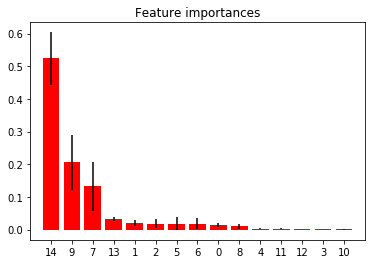

In [8]:
# Check feature importance random forest model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, x_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

### Check model metrics
Recall is most important to ensure dangerous trees are mantained, we don't want to miss tree branches that will fall!

In [ ]:
# Generate target predictions using the random forest model with the specified threshold (0.5 now)
x_test = dt_test.drop(['zipcode','Fall','address'],axis=1)
y_test = dt_test.Fall
y_pred = (forest.predict_proba(x_test)[:,1] >= 0.5).astype(bool)

In [27]:
# Check accuracy of model on test data
accuracy_score(y_test,y_pred)

0.7450412330525166

In [25]:
# Check ROC-AUC for model on test data
roc_auc_score(y_test,y_pred)

0.7630665493474108

In [26]:
# Check confusion matrix for model on test data
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall']
)

,Predicted No Fall,Predicted Fall
True No Fall,113962,39209
True Fall,921,3306


### Generate tree branch fall probabilities from the no service request model
Then save these in an output file

In [153]:
# Calculate Fall probabilities of train and test trees from the no service request model
prob_train = forest.predict_proba(x_train)
prob_test = forest.predict_proba(x_test)

In [154]:
# combine the fall probabilities for the train and test trees, then append to other data to add fall probabilities to the tree census data
df_train['fallprob'] = prob_train[:,1]
df_test['fallprob'] = prob_test[:,1]
tree_branch_fall_prob_df = df_train.append(df_test)

C:\Users\Brianne\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Brianne\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [159]:
# drop branch fall data from the tree census data with branch fall probabilities
tree_branch_fall_prob_df.drop('Fall',axis=1,inplace=True)

Index(['tree_id', 'address', 'curb_loc', 'guards', 'health', 'root_grate',
       'root_other', 'root_stone', 'sidewalk', 'spc_common', 'steward',
       'tree_dbh', 'trnk_light', 'trnk_other', 'trnk_wire', 'zipcode',
       'impervious_pct', 'heightroof', 'fallprob'],
      dtype='object')

In [161]:
# Export data
tree_branch_fall_prob_df.to_csv('Data/FinalOutputs/ServiceRequestModelOutput.csv')

### Model tuning code
Code from model tuning was moved down here, it doesn't need to be re-run for modeling, and would take some time to run

Gridsearch:

In [15]:
#Try gridsearch to train model on 20% of data

# The target encoding needs to be updated to prevent data leakage
# Target encode tree species descriptor data
# First split train and test data to prevent data leakage
grid_df_train, grid_df_test = train_test_split(model_data_df, random_state=1,test_size=0.8)

# Now, target encode training and test data based on training data encoding
grid_target_dict = grid_df_train.groupby('spc_common')['Fall'].mean()
grid_df_train['spc_common'] = grid_df_train['spc_common'].map(grid_target_dict)
grid_df_test['spc_common'] = grid_df_test['spc_common'].map(grid_target_dict)

# Set up feature (x) and target (y) data
grid_x_train = grid_dt_train.drop(['zipcode','Fall','address'],axis=1)
grid_y_train = grid_dt_train.Fall

# Random forest model for grid search
grid_forest = RandomForestClassifier(random_state = 1)

# Grid search parameters
n_estimators = [100, 300]
max_depth = [10, 30, 50]
class_weight = ['balanced', 'balanced_subsample', None]
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth, class_weight=class_weight)

# Run grid search
gridF = GridSearchCV(grid_forest, hyperF, scoring = ['recall','precision'], n_jobs = -1)
gridF.fit(grid_x_train, grid_y_train)

# Check grid search results
gridF.cv_results_['mean_test_score']

# See optimal gridsearch parameters
gridF.best_params_

# Predict test data
grid_x_test = grid_df_test.drop(['zipcode','Fall','address'],axis=1)
grid_y_test = grid_df_test.Fall
grid_y_pred = gridF.predict(grid_x_test)

# check grid search result roc-auc and confusion matrix
roc_auc_score(y_test,y_pred)

pd.DataFrame(confusion_matrix(y_test, y_pred),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall'])

C:\Users\Brianne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, '2-class Precision-Recall curve')

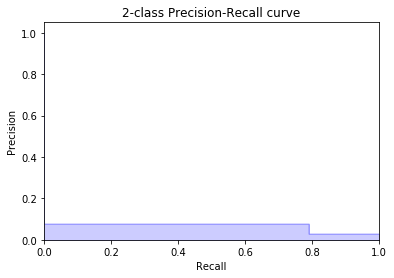

In [13]:
# Check the random forest precision recall curve to look at thresholds

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_train, forest.predict(x_train))

# Plot
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

### EDA 
Code used to create some of the EDA figures

In [ ]:
# Look at tree species with most falls
target_dict.sort_values()[100:133].plot.bar()